In [1]:
import jax
import jaxlib
print(jaxlib.__version__)
print(jax.__version__)

0.4.4
0.4.5


In [2]:
__plot__ = False

In [3]:
%load_ext autoreload
%autoreload 2

### Imports

In [4]:
from kinn.basis import model
from kinn.basis.nnx import nn
from kinn.basis import plt, jit, optimizers, onp, jnp
from kinn.graphics.generators import gen_gif, gen_sample_gif
from kinn.basis import jnp, random, itertools, clear_output, grad, jacfwd, hessian, vmap
from kinn.basis import plt, MaxNLocator, FormatStrFormatter, HTML, animation, cm,\
                    left, right, bottom, top, wspace, hspace, jnp, make_axes_locatable, griddata
from scipy.integrate import solve_ivp
import warnings
warnings.filterwarnings('ignore')

In [5]:
from jax.tree_util import tree_flatten, tree_unflatten
from jax.flatten_util import ravel_pytree
from jax.nn import sigmoid

Useful activation functions

In [6]:
swish      = jit(lambda x : x/(1.+jnp.exp(-x)))
relu       = jit(lambda x : x*(x>0))
#tanh       = jit(lambda x : jnp.tanh(x))
#sigmoid    = jit(lambda x : jnp.reciprocal(1.+jnp.exp(-x)))
from jax.nn import sigmoid
from jax.nn import swish
from jax.nn import tanh
gauss      = jit(lambda x : jnp.exp(-x**2))
sin        = jit(lambda x : jnp.sin(x))
cos        = jit(lambda x : jnp.cos(x))

## Robust KINNs
### Examples

---


#### iv. Latent Kinetics Type gdacs

Reaction between radicals $D*$, $E*$ and $F*$ adds further complexity to surface reaction.

$$A\underset{k_{-1}}{\stackrel{k_1}{\rightleftharpoons}} A*\notag\\
B\underset{k_{-2}}{\stackrel{k_2}{\rightleftharpoons}} B*\notag\\
C\underset{k_{-3}}{\stackrel{k_3}{\rightleftharpoons}} C*\notag\\
A*+*\underset{k_{-4}}{\stackrel{k_4}{\rightleftharpoons}} 2D*\notag\\
B*+*\underset{k_{-5}}{\stackrel{k_5}{\rightleftharpoons}} 2E*\notag\\
D*\:+\:E*\underset{k_{-6}}{\stackrel{k_{6}}{\rightleftharpoons}} F*\:+\:*\notag\\
F*\:+\:E*\underset{k_{-7}}{\stackrel{k_{13}}{\rightleftharpoons}} C*\:+\:*\notag$$

A dictionary of stoichiometry matrices and with kinetic parameters (rate constants).

All reactions are considered reversible

### Code

In [7]:
exp = jit(lambda x : jnp.exp(-x**2))

In [8]:
def  get_stoich(pars,reverse=True):
    import numpy as np
    getpos              = lambda x : jnp.where(np.array(pars['sps'])==x)[0][0]
    M                   = jnp.zeros([len(pars['sps']),(1+reverse*1)*len(pars['reacs'])])
    for r, reac in enumerate(pars['reacs']):
        for sign,_ in zip((-1,1),reac):
            for s in _:
                try:
                    coeff   = int(s[0])
                    s       = s[1:]
                except:
                    coeff   = 1
                coeff *= sign
                M = M.at[getpos(s),r*(1+reverse*1)].set(coeff)
                if reverse:
                    M = M.at[getpos(s),r*2+1].set(-coeff)
    return M

pars = {i:dict() for i in range(6)}

# visible boundary conditions
t0                  = 0.
#bcv                 = [[0.6,0.4,0.0],[0.2,0.3,0.5],[0.9,0.05,0.05],[0.05,0.9,0.05],[0.05,0.05,0.9]]
bcv                 = [[0.2,0.3,0.5],[0.6,0.4,0.0]]
trig                = True

pars[0]['type']     = 'homogeneous'
pars[0]['sps']      = ['A','B','C']
pars[0]['reacs']    = [[['A','B'],['C']]]
# pars[0]['stoich']   = jnp.array([[-1,-1, 1],
#                                 [ 1, 1,-1]]).T
pars[0]['stoich']   = get_stoich(pars[0])
pars[0]['kinpars']  = jnp.array([10.,1.])
pars[0]['bc']       = [[jnp.array(_) for _ in [[t0],bcv_]] for bcv_ in bcv]
pars[0]['nncpars']  = [{'forward': {'predictor':{'trig':False, 'damp':True,'nobs':3,'bc':bc_,'nn_scale': 0.001}},\
                       'inverse': {'predictor':{'trig':False, 'damp':False,'nobs':3,'bc':None,'nn_scale': 0.001},\
                                    'inference':{'trig':False, 'damp':False,'nobs':0,'bc':None,'nn_scale': 0.001}}} for bc_ in pars[0]['bc']]
pars[0]['nnmpars']  = {'forward': {'layers_sizes'  : [[1,5,5,5,pars[0]['stoich'].shape[0]]],
                       'act_fun'                   : [sigmoid,swish,sigmoid],
                       'nn_scale'                  : 0.001},
                       'inverse' : {'layers_sizes' : [[1,5,5,pars[0]['stoich'].shape[0]]],
                       'act_fun'                   : [swish,sigmoid],
                       'nn_scale'                  : 0.001}}
pars[0]['nntpars']  = {'layers_sizes' : [[1,3,1]],
                       'act_fun'      : [swish,tanh,swish,tanh],
                       'nn_scale'     : 0.001}

pars[1]['type']     = 'heterogeneous'
pars[1]['sps']      = ['A','B','C','A*','B*','C*','*']
pars[1]['reacs']    = [[['A','*'],['A*']],\
                       [['B','*'],['B*']],\
                       [['C','*'],['C*']],\
                       [['A*','B*'],['C*','*']]]
pars[1]['stoich']   = get_stoich(pars[1])             
pars[1]['kinpars']  = jnp.array([.5,.2,2.,3.,10.,2.,5.,4])*20.
pars[1]['bc']       = [[jnp.array(_) for _ in [[t0],bcv_+[0.]*(pars[1]['stoich'].shape[0]-1-len(bcv_))+[1.]]] for bcv_ in bcv]
pars[1]['nncpars']  = [{'forward': {'predictor':{'trig':True, 'damp':True,'nobs':3,'bc':bc_,'nn_scale': 0.001}},\
                       'inverse': {'predictor':{'trig':True, 'damp':False,'nobs':3,'bc':None,'nn_scale': 0.001},\
                                    'inference':{'trig':True, 'damp':False,'nobs':0,'bc':None,'nn_scale': 0.001}}} for bc_ in pars[1]['bc']]
pars[1]['nnmpars']  = {'forward': {'layers_sizes'  : [[1,10,10,10,pars[1]['stoich'].shape[0]-1]],
                       'act_fun'                   : [sigmoid,swish,sigmoid],
                       'nn_scale'                  : 0.001},
                       'inverse' : {'layers_sizes' : [[1,15,15,pars[1]['stoich'].shape[0]-1]],
                       'act_fun'                   : [swish,swish],#[swish,jit(lambda x : jnp.exp(-x**2)),swish],#[tanh,swish,tanh,tanh,swish],
                       'nn_scale'                  : 0.001},
                       'inference' : {'layers_sizes' : [[1,10,10,10,pars[1]['stoich'].shape[0]-1-pars[1]['nncpars'][0]['inverse']['predictor']['nobs']]],
                       'act_fun'                   : [swish,swish,tanh],#[swish,jit(lambda x : jnp.exp(-x**2)),swish],#[tanh,swish,tanh,tanh,swish],
                       'nn_scale'                  : 0.001}}
pars[1]['nntpars']  = {'layers_sizes' : [[1,3,1]],
                       'act_fun'      : [swish,tanh,swish,tanh],
                       'nn_scale'     : 0.001}

pars[2]['type']     = 'heterogeneous'
pars[2]['sps']      = ['A','B','C','A*','C*','*']
pars[2]['reacs']    = [[['A','*'],['A*']],\
                       [['C','*'],['C*']],\
                       [['B','A*'],['C*']]]
pars[2]['stoich']   = get_stoich(pars[2])       
pars[2]['kinpars']  = jnp.array([.5,.2,1.,2.,5.,4])*20.
pars[2]['bc']       = [[jnp.array(_) for _ in [[t0],bcv_+[0.]*(pars[2]['stoich'].shape[0]-1-len(bcv_))+[1.]]] for bcv_ in bcv]
pars[2]['nncpars']  = [{'forward': {'predictor':{'trig':True, 'damp':True,'nobs':3,'bc':bc_,'nn_scale': 0.001}},\
                       'inverse': {'predictor':{'trig':True, 'damp':False,'nobs':3,'bc':None,'nn_scale': 0.001},\
                                    'inference':{'trig':True, 'damp':False,'nobs':0,'bc':None,'nn_scale': 0.001}}} for bc_ in pars[2]['bc']]
pars[2]['nnmpars']  = {'forward': {'layers_sizes'  : [[1,8,8,8,pars[2]['stoich'].shape[0]-1]],
                       'act_fun'                   : [sigmoid,swish,sigmoid],
                       'nn_scale'                  : 0.001},
                       'inverse' : {'layers_sizes' : [[1,12,12,pars[2]['stoich'].shape[0]-1]],
                       'act_fun'                   : [swish,swish],#[swish,jit(lambda x : jnp.exp(-x**2)),swish],#[tanh,swish,tanh,tanh,swish],
                       'nn_scale'                  : 0.001},
                       'inference' : {'layers_sizes' : [[1,8,8,8,pars[2]['stoich'].shape[0]-1-pars[2]['nncpars'][0]['inverse']['predictor']['nobs']]],
                       'act_fun'                   : [swish,swish,swish],#[swish,jit(lambda x : jnp.exp(-x**2)),swish],#[tanh,swish,tanh,tanh,swish],
                       'nn_scale'                  : 0.001}}
pars[2]['nntpars']  = {'layers_sizes' : [[1,3,1]],
                       'act_fun'      : [swish,tanh,swish,tanh],
                       'nn_scale'     : 0.001}

pars[3]['type']     = 'heterogeneous'
pars[3]['sps']      = ['A','B','C','A*','B*','C*','D*','*']
pars[3]['reacs']    = [[['A','*'],['A*']],\
                       [['B','*'],['B*']],\
                       [['C','*'],['C*']],\
                       [['B*','*'],['2D*']],\
                       [['A*','D*'],['C*','*']]]
pars[3]['stoich']   = get_stoich(pars[3])  
pars[3]['kinpars']  = jnp.array([.5,.2,.4,.1,.3,.2,30.,10.,50.,40.])*1.#
#pars[3]['bc']       = [[jnp.array(_) for _ in [[t0],bcv_+[0.]*(pars[3]['stoich'].shape[0]-1-len(bcv_))+[1.]]] for bcv_ in bcv]
pars[3]['bc']       = [[jnp.array(_) for _ in [[t0],bcv_+[1./(pars[3]['stoich'].shape[0]-len(bcv_))]*(pars[3]['stoich'].shape[0]-len(bcv_))]] for bcv_ in bcv]
pars[3]['nncpars']  = [{'forward': {'predictor':{'trig':True, 'damp':True,'nobs':3,'bc':bc_,'nn_scale': 0.001}},\
                       'inverse': {'predictor':{'trig':True, 'damp':False,'nobs':3,'bc':None,'nn_scale': 0.001},\
                                    'inference':{'trig':True, 'damp':False,'nobs':0,'bc':None,'nn_scale': 0.001}}} for bc_ in pars[3]['bc']]
pars[3]['nnmpars']  = {'forward': {'layers_sizes'  : [[1,12,12,12,pars[3]['stoich'].shape[0]-1]],
                       'act_fun'                   : [sigmoid,swish,sigmoid],
                       'nn_scale'                  : 0.001},
                       'inverse' : {'layers_sizes' : [[1,16,16,16,pars[3]['stoich'].shape[0]-1]],
                       #'act_fun'                   : [jnp.tanh,swish,jnp.tanh],
                       'act_fun'                   : [swish]*3,
                    #    'nn_scale'                  : 0.001},
                    #     'inverse' : {'layers_sizes' : [[1,2,4,8,12,16,pars[3]['stoich'].shape[0]-1]],
                    #    'act_fun'                   : [jnp.tanh]*5,
                    #    'nn_scale'                  : 0.001},
                    #    'inference' : {'layers_sizes' : [[1,16,16,16,pars[3]['stoich'].shape[0]-1-pars[2]['nncpars'][0]['inverse']['predictor']['nobs']]],
                    #    'act_fun'                   : [swish,swish,swish],
                       'nn_scale'                  : 0.001}}
pars[3]['nntpars']  = {'layers_sizes' : [[1,6,1]],
                       'act_fun'      : [swish,tanh,swish,tanh],
                       'nn_scale'     : 0.001}

pars[4]['type']     = 'heterogeneous'
pars[4]['sps']      = ['A','B','C','A*','B*','C*','D*','E*','F*','*']
pars[4]['reacs']    = [[['A','*'],['A*']],\
                       [['B','*'],['B*']],\
                       [['C','*'],['C*']],\
                       [['A*','*'],['2D*']],\
                       [['B*','*'],['2E*']],\
                       [['D*','E*'],['F*','*']],\
                       [['F*','E*'],['C*','*']]]
pars[4]['stoich']   = get_stoich(pars[4])  
pars[4]['kinpars']  = jnp.array([25.,10.,30.,15.,20.,50.,800.,1200.,200.,100.,800.,300.,700.,200.])*0.8
pars[4]['bc']       = [[jnp.array(_) for _ in [[t0],bcv_+[0.]*(pars[4]['stoich'].shape[0]-1-len(bcv_))+[1.]]] for bcv_ in bcv]
#pars[4]['bc']       = [[jnp.array(_) for _ in [[t0],bcv_+[0.1,0.2,0.3,0.1,0.05,0.05,0.2]]] for bcv_ in bcv]
pars[4]['nncpars']  = [{'forward': {'predictor':{'trig':True, 'damp':True,'nobs':3,'bc':bc_,'nn_scale': 0.001}},\
                        'inverse': {'predictor':{'trig':True, 'damp':False,'nobs':3,'bc':None,'nn_scale': 0.001},\
                                    'inference':{'trig':True, 'damp':False,'nobs':0,'bc':None,'nn_scale': 0.001}}} for bc_ in pars[4]['bc']]
pars[4]['nnmpars']  = {'forward': {'layers_sizes'  : [[1,5,5,5,pars[4]['stoich'].shape[0]-1]],
                       #'act_fun'                   : [sigmoid,swish,sigmoid],
                       'nn_scale'                  : 0.001},
                       'inverse' : {'layers_sizes' : [[1,20,20,20,pars[4]['stoich'].shape[0]-1]],
                       'act_fun'                   : [jnp.tanh, swish, jnp.tanh],
                    #     'inverse' : {'layers_sizes' : [[1,2,5,10,15,20,pars[4]['stoich'].shape[0]-1]],
                    #    'act_fun'                   : [jnp.tanh]*5,
                       #'act_fun'                   : [exp]*3,
                    #    'inverse' : {'layers_sizes' : [[1,20,pars[4]['stoich'].shape[0]-1]],
                        #'act_fun'                   : [swish]*3,                    
                       'nn_scale'                  : 0.001}}#,
                    #   'inference' : {'layers_sizes' : [[1,20,20,20,pars[4]['stoich'].shape[0]-1-pars[3]['nncpars'][0]['inverse']['predictor']['nobs']]],
                    #    'act_fun'                   : [swish,swish,swish],
                    #    'nn_scale'                  : 0.001}}
pars[4]['nntpars']  = {'layers_sizes' : [[1,6,1]],
                       'act_fun'      : [swish,tanh,swish],
                       'nn_scale'     : 0.001}


pars[5]['type']     = 'heterogeneous'
pars[5]['sps']      = ['A','B','C','A*','B*','C*','*']
pars[5]['reacs']    = [[['A','*'],['A*']],\
                       [['B','*'],['B*']],\
                       [['C','*'],['C*']],\
                       [['A','B*'],['C*']],\
                       [['B','A*'],['C*']],\
                       [['A*','B*'],['C*','*']],\
                       [['2A*'],['B*','*']],\
                       [['A','A*'],['B*']]]#,\
                    #    [['A*','B'],['A','B*']],
                    #    [['B*','C'],['C*','B']]]
pars[5]['stoich']   = get_stoich(pars[5])                
pars[5]['kinpars']  = jnp.array([.5,.4,2.,3.,10.,2.,0.1,15.,9.,0.2,5.,4,5.,17,100.,1.])#,.2,.8,.2,.05])
pars[5]['bc']       = [[jnp.array(_) for _ in [[t0],bcv_+[1./(pars[5]['stoich'].shape[0]-len(bcv_))]*(pars[5]['stoich'].shape[0]-len(bcv_))]] for bcv_ in bcv]
pars[5]['nncpars']  = [{'forward': {'predictor':{'trig':True, 'damp':True,'nobs':3,'bc':bc_,'nn_scale': 0.001}},\
                       'inverse': {'predictor':{'trig':True, 'damp':False,'nobs':3,'bc':None,'nn_scale': 0.001},\
                                    'inference':{'trig':True, 'damp':False,'nobs':0,'bc':None,'nn_scale': 0.001}}} for bc_ in pars[5]['bc']]
pars[5]['nnmpars']  = {'forward': {'layers_sizes'  : [[1,10,10,10,pars[5]['stoich'].shape[0]-1]],
                       'act_fun'                   : [sigmoid,swish,sigmoid],
                       'nn_scale'                  : 0.001},
                       'inverse' : {'layers_sizes' : [[1,12,12,12,pars[5]['stoich'].shape[0]-1]],
                       'act_fun'                   : [swish]*3,#[swish,jit(lambda x : jnp.exp(-x**2)),swish],#[tanh,swish,tanh,tanh,swish],
                       'nn_scale'                  : 0.001},
                       'inference' : {'layers_sizes' : [[1,10,10,10,pars[5]['stoich'].shape[0]-1-pars[5]['nncpars'][0]['inverse']['predictor']['nobs']]],
                       'act_fun'                   : [swish,swish,tanh],#[swish,jit(lambda x : jnp.exp(-x**2)),swish],#[tanh,swish,tanh,tanh,swish],
                       'nn_scale'                  : 0.001}}
pars[5]['nntpars']  = {'layers_sizes' : [[1,3,1]],
                       'act_fun'      : [swish,tanh,swish,tanh],
                       'nn_scale'     : 0.001}                       

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Model parameters (rate constants): `model_params0`  
Boundary conditions (concentrations at $t=0$): `bc0`

Model function, `x` are state variables, `t` the independet variable (e.g. time).

In [9]:
from kinn.basis import *
from kinn.basis.mle import opt as opt_

In [10]:
__reload__ = False
__errors__ = {}
__results__ = {}

addon = '_alpha107sens_uq_full'
cutoff      = 1e-1#-1

__pars_results__ = dict()

from jax.config import config
config.update('jax_disable_jit', False)

no, tag, mode = 4, 'invvwn', 'inverse'

model_scale = 1e-3 # model scale (assume low so as not to be bias)
model_nn = model(pars[no]['stoich'],nobs=3,model_scale=model_scale)


model_ = model(pars[no]['stoich'],nobs=3)
model_.params = [pars[no]['kinpars']]

def gen_data(n_points,i):
    @jit
    def ode(t,C):
        return model_.single_eval([jnp.log(pars[no]['kinpars'])],[C,[]]).flatten()

    tmax = 20 
    t_eval = (jnp.logspace(0,jnp.log10(tmax+1),n_points)-1.)/tmax
    print((pars[no]['bc'][i][0], tmax), pars[no]['bc'][i][1])
    sol = solve_ivp(ode, (pars[no]['bc'][i][0], tmax), pars[no]['bc'][i][1], t_eval = t_eval, method='LSODA',atol=1e-20,rtol=1e-20)

    return t_eval.reshape(-1,1), sol.y.T

nnms = []
nnts = []
nncs = [] # one per dataset
onncs = [] # no rndecomp
nnis = [] # for inference
for i in range(len(pars[no]['bc'])):
    nnm = nn(**pars[no]['nnmpars'][mode])
    nnms += [nnm]
    if tag == 'inv':
        inference = True
        nncs += [nn_npt([nnm], mode=mode,**pars[no]['nncpars'][i][mode]['predictor'],model=model_)]
        onncs += [nn_npt([nnm], mode=mode,**pars[no]['nncpars'][i][mode]['predictor'],model=model_,rndecomp=False)]
    else:
        inference = False
        nncs += [nn_npt([nnm], mode=mode,**pars[no]['nncpars'][i][mode]['predictor'],model=model_)]
        onncs += [nn_npt([nnm], mode=mode,**pars[no]['nncpars'][i][mode]['predictor'],model=model_,rndecomp=False)]

num_epochs = 100 # 100
num_iter   = 300 # 150 

if tag.endswith('sc') or tag.endswith('wn'):
    scale = True
else:
    scale = False

print('scale',scale)
tobj = opt_(nncs, model_nn, num_iter=num_iter, num_epochs=num_epochs, verbose=True,\
        mode=mode, historian=True, 
        tol=1e-10, stol=5e-3, nobs=pars[no]['nncpars'][i][mode]['predictor']['nobs'],\
        iter_data=[],inference=inference, kl_inference=False)
tobj.__setattr__('err_tags',['MLE MODEL','MLE DATA','DIV'])

oobj = opt_(onncs, model_nn, num_iter=num_iter, num_epochs=num_epochs, verbose=True,\
        mode=mode, historian=True, 
        tol=1e-10, stol=5e-3, nobs=pars[no]['nncpars'][i][mode]['predictor']['nobs'],\
        iter_data=[],inference=inference, kl_inference=False)
oobj.__setattr__('err_tags',['MLE MODEL','MLE DATA','DIV'])

if __reload__:
    try:
        tobj.load('opt_{}_{}{}.npz'.format(tag,no,addon))
    except:
        print('Load failed: {} {}'.format(tag,no))
        __errors__.update({'LOAD_FAILED':(tag,no)})

datas0 = []
datas0_diff = []
for i in range(len(pars[no]['bc'])):
    t, x = gen_data(100,i)
    data0 = [(t,x.copy(),t,model_.batched_eval([jnp.log(pars[no]['kinpars'])],[x,[]]))]
    datas0 += data0
dstack = jnp.vstack([_[1][:,pars[no]['nncpars'][i][mode]['predictor']['nobs']:] for _ in datas0])

s_ = jnp.max(dstack,axis=0)

datas  = []

for i in range(len(pars[no]['bc'])):

    t, x, t_, dx = datas0[i]
    def intra_points(t,n):
        if n > 0:
            return jnp.sort(jnp.vstack((t,jnp.vstack((t[:-1,:]+jnp.diff(t,axis=0)/(n+1)*(i+1) for i in range(n))))))
        else:
            return t
    
    t_ = intra_points(t,0)

    d = x[:,pars[no]['nncpars'][i][mode]['predictor']['nobs']:]
    d = d/s_
    x_sc = jnp.hstack((x[:,:pars[no]['nncpars'][i][mode]['predictor']['nobs']],d))
    x_scwn = x_sc + random.normal(random.PRNGKey(i),x_sc.shape)*0.025
    #x_scwn = x_scwn*(x_scwn>=0.)   
    data = [(t,x_scwn,t_)]
    datas  += data

tobj.tol  = 1e-1#1e-1
tobj.rtol = 1e-5
tobj.kltol = 1e-5
opt_dict  = {'sm':{'optimizer':optax.adam,'kwargs':{'learning_rate':1e-4,'eps':1e-12,'b1':0.9,'b2':0.9999}},
                'pm':{'optimizer':optax.adam,'kwargs':{'learning_rate':1e-4,'eps':1e-12,'b1':0.9,'b2':0.9999}},
                'scales':{'optimizer':optax.set_to_zero,'kwargs':{}}}
                #'scales':{'optimizer':optax.adam,'kwargs':{'learning_rate':1e-4,'eps':1e-12,'b1':0.9,'b2':0.9999}}}
tobj.set_optimizer({_:{'optimizer':opt_dict[_]['optimizer'],'kwargs':opt_dict[_]['kwargs']} for _ in opt_dict.keys()})
tobj.jit_compile()
for step in range(10):
    print(no,tag,step)
    tobj.train(datas,alpha=1.,beta=1.,reperror=False,mureg=True,center=True)

#__pars_results__[no][tag] = [pars[no]['kinpars'][:],jnp.exp(tobj.params['pm'][0])[:]]

__results__['opt_{}_{}{}'.format(tag,no,addon)] = tobj.get_error_metrics([_[:3] for _ in datas0])
tobj.dump('opt_{}_{}{}'.format(tag,no,addon))

Epoch: 1000, Loss Batch: 1.36964e+00, Loss Data: 1.36964e+00 Loss CV: 1.36964e+00, Fit MLE MODEL: 3.40809e-02, Fit MLE DATA: 2.71119e+00


In [11]:
addon = '_alpha107sens_uq_full'
tobj.load('opt_{}_{}{}.npz'.format(tag,no,addon))
pars_nn = tobj.params['sm']
pars_m = tobj.params['pm']
#pars_sc = tobj.params[2]

In [12]:
tobj.ts = datas0[0][0]

In [13]:
tobj.tol = 1e-20  
adam_kwargs  = {'learning_rate':1e-5,'eps':1e-18,'b1':0.9,'b2':0.999}
tobj.set_optimizer({_:{'optimizer':optax.adam,'kwargs':adam_kwargs} for _ in ['sm','pm']})
tobj.jit_compile()
tobj.num_iter = 300

In [14]:
obj = jnp.load('../paper_reg/trainer_invvwn_3_mle.npz',allow_pickle=True)
oiter_data = obj['data'].tolist()['iter_data'][::300]
_ = oiter_data[0]
oobj.params = {'sm':_[1][0][0],'pm':_[1][0][1],'mpars':[]}
oobj.ts = tobj.ts
oobj.send_parameters()
oobj.jit_compile()

Graphics Aesthetics

In [15]:
import matplotlib as mpl
import seaborn as sns

from mpl_toolkits.axes_grid1.axes_size import Fixed, Scaled
from mpl_toolkits.axes_grid1.axes_divider import Divider, Size
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                        AutoMinorLocator)
from matplotlib.lines import Line2D
%matplotlib inline
#mpl.use("pgf")
#mpl.use("pdf")
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['xtick.major.bottom'] = True
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.left'] = True
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.major.right'] = True
mpl.rcParams['xtick.major.size'] = 2.
mpl.rcParams['xtick.major.width'] = .25
mpl.rcParams['ytick.major.size'] = 2.


mpl.rcParams.update({'font.size':12})
mpl.rcParams.update({'axes.unicode_minus':False})
mpl.rcParams.update({'legend.handlelength': 1})
mpl.rcParams.update({'mathtext.fontset':'cm'})
mpl.rcParams.update({'font.size':10})
mpl.rcParams.update({'axes.unicode_minus':True})
mpl.rcParams.update({
'pgf.texsystem': "pdflatex",   
'pgf.rcfonts': False, 
"text.usetex": True,
'font.sans-serif' : "CMU Sans Serif",
"font.family": "sans-serif",
'font.serif': ["Computer Modern Roman"],
'mathtext.default': 'regular',
#'text.latex.preamble': '\n'.join([r"\usepackage[utf8]{inputenc}",r"\usepackage{amsmath}",r"\usepackage{amssymb}",r"\usepackage{bm}",r"\DeclareUnicodeCharacter{2212}{\ensuremath{-}}"]),
#'pgf.preamble': '\n'.join([r"\usepackage[utf8]{inputenc}",r"\usepackage{amsmath}",r"\usepackage{amssymb}",r"\usepackage{bm}",r"\DeclareUnicodeCharacter{2212}{\ensuremath{-}}"])
 'text.latex.preamble': '\n'.join([r"\usepackage[utf8]{inputenc}",  r'\usepackage{siunitx}', r'\sisetup{detect-all}', r"\DeclareUnicodeCharacter{2212}{${-}$}",r"\newcommand{\minus}{$-$}",r"\usepackage{amsmath}",r"\usepackage{amssymb}",r"\usepackage{amsthm}",r"\usepackage{bm}"]),
 'pgf.preamble': '\n'.join([r"\usepackage[utf8]{inputenc}",  r'\usepackage{siunitx}', r'\sisetup{detect-all}',r"\DeclareUnicodeCharacter{2212}{${-}$}",r"\newcommand{\minus}{$-$}",r"\usepackage{amsmath}",r"\usepackage{amssymb}",r"\usepackage{amsthm}",r"\usepackage{bm}"])
})

fs=12.

mpl.rcParams.update({   'figure.titlesize' : fs,
                        })
mpl.rcParams.update({   'axes.titlesize'   : fs*10/12.,
                        'axes.labelsize'   : fs*10/12.,
                        'lines.linewidth'  : 1.,
                        'lines.markersize' : fs*10/12.,
                        'xtick.labelsize'  : fs*10/12.,
                        'ytick.labelsize'  : fs*10/12.})
mpl.rcParams.update({'legend.handletextpad':.4,
                'legend.handlelength':.6,
                'legend.columnspacing':.5,
                'legend.borderaxespad':.5,
                'legend.fontsize' : fs*10/12.})
mpl.rcParams['axes.linewidth'] = 0.75 #set the value globally

# plt.rcParams.update({
#     'pgf.texsystem': "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
#     "pgf.preamble": "\n".join([
#          r"\usepackage{bm}",
#     ]),
#     'font.serif': ["Computer Modern Roman"],
#     'text.latex.preamble': r'\usepackage{bm}',
# })

def fix_color(lines1,lines2):
    for _1,_2 in zip(lines1,lines2):
        if _2.get_markeredgecolor()!='None':
            _2.set_markeredgecolor(_1.get_markeredgecolor())
        
        if _2.get_color()!='None':
            _2.set_color(_1.get_color())

In [16]:
tobj.get_scales(datas)
tobj.upd(tobj.params,datas,tobj.zn,False,True,False)

In [17]:
omles = jnp.array([oobj._smp_khd_fun({'pm':{'interp':_[-2][0],'pm':_[-2][0]},'interp':_[-2][1]},{'interp':_[-1],'pm':_[-1]},\
        {'sm':_[1][0][0],'pm':_[1][0][1],'mpars':[]},\
        tobj.sigmas,\
        tobj.mus,\
        tobj.vars,
        tobj.ts,
        tobj.tsm,
        tobj.zn, reperror=False,mureg=True)\
        for _ in oiter_data[:]])

In [18]:
mles = jnp.array([tobj._smp_khd_fun(_[6][0],_[7][0],_[1][0],tobj.sigmas,tobj.mus,tobj.vars,tobj.ts,tobj.tsm,tobj.zn, reperror=False,mureg=True) for _ in tobj.iter_data[5:-1:30]])

In [19]:
alphas = jnp.log(jnp.array([_[2][0][0] for _ in oiter_data[:]]))
amin = jnp.argmin(jnp.array([jnp.linalg.norm((_[1][0][1][0])-jnp.log(pars[4]['kinpars'])) for _ in oiter_data[:]]))

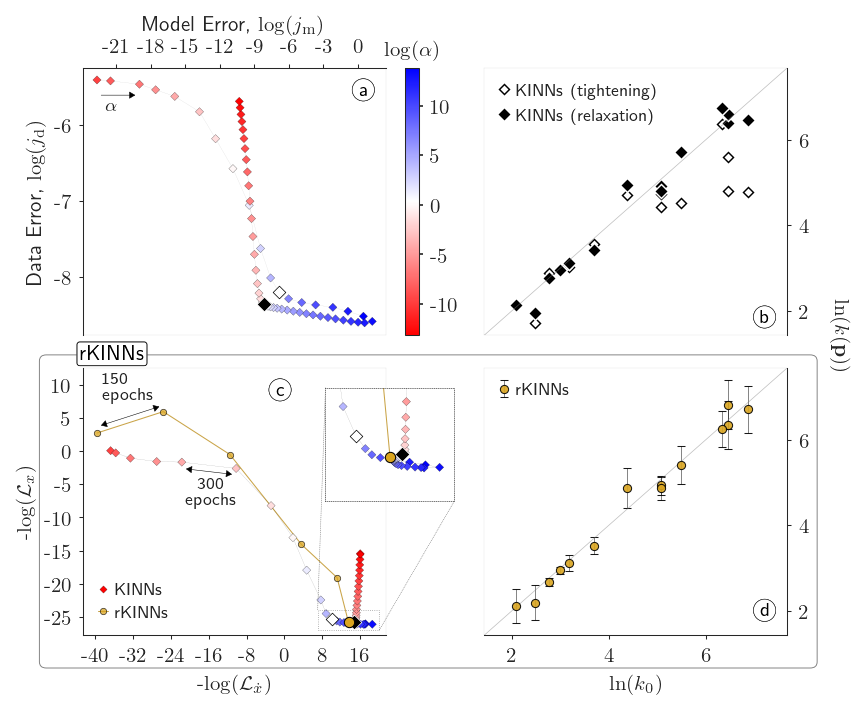

In [20]:
def plot():
        fig = plt.figure(figsize=[6+.15,2*2.75],dpi=150)

        # Sizes are in inches.
        sc = 1.25
        msc = 1.75
        dx = 0.95*sc*2.55*2/3.
        dy = 0.95*sc*1.5

        horiz = [Size.Fixed(dx), Size.Fixed(sc*0.1)]+[Size.Fixed(sc*.075),Size.Fixed(sc*0.35)]+[Size.Fixed(dx), Size.Fixed(sc*0.075)]
        vert = [Size.Fixed(dy), Size.Fixed(sc*0.175)]+[Size.Fixed(dy), Size.Fixed(sc*0.25)]#+[Size.Fixed(dy*0.05), Size.Fixed(sc*0.075)]

        rect = (0.01,0.01,0.02,0.02)
        # Divide the axes rectangle into a grid with sizes specified by horiz * vert.
        divider = Divider(fig, rect, horiz, vert, aspect=False)

        # The rect parameter will actually be ignored and overridden by axes_locator.
        axs = []
        axs += [fig.add_axes(rect, axes_locator=divider.new_locator(nx=0, ny=0))]
        axs += [fig.add_axes(rect, axes_locator=divider.new_locator(nx=0, ny=2))]
        axs += [fig.add_axes(rect, axes_locator=divider.new_locator(nx=4,ny=0, ny1=1))]
        axs += [fig.add_axes(rect, axes_locator=divider.new_locator(nx=4,ny=2, ny1=3))]
        axs += [fig.add_axes(rect, axes_locator=divider.new_locator(nx=2, ny=2,ny1=3))]

        from mpl_toolkits.axes_grid1.inset_locator import inset_axes

        ax  = axs[1]
        ax2_ = axs[0]
        axp  = axs[3]
        axp_  = axs[2]
        axsc = axs[4]
        mkm = 4

        axins = ax2_.inset_axes([0.8, 0.5, 0.425, 0.425])
        #axins.set_position([1,10,1,1])

        odata = oiter_data[3:]
        _omles = omles[3:]
        amin = jnp.argmin(jnp.array([jnp.linalg.norm((_[1][0][1][0])-jnp.log(pars[4]['kinpars'])) for _ in odata[:]]))
        cm = plt.cm.get_cmap('bwr').reversed()

        c2 = 'C0'; cinit = 'black'; cmid = 'black'; cfinal = 'black'
        Lmid = 11

        _L  = jnp.log(jnp.array([_[3][0] for _ in odata]))
        m   = jnp.array([_[1][0][1][0] for _ in odata])
        _alphas = jnp.log(jnp.array([_[2][0][0] for _ in odata]))
        its = jnp.array([_[0] for _ in odata]).reshape(-1,1)
        _L  = jnp.hstack((its,(_L[:,:])))
        mu_m, std_m = [_(m,axis=1) for _ in (jnp.mean,jnp.std)]
        m_ = (m-mu_m.reshape(-1,1))/std_m.reshape(-1,1)
        p = pars[mkm]['kinpars'].copy()
        mu_p, std_p = [_(p) for _ in (jnp.mean,jnp.std)]
        p_ = (p-mu_p)/std_p
        r  = m_.dot(p_)/len(p_)
        p1 = p_.copy()
        m1 = m_.copy()
        uq = jnp.unique(_L[:,0])
        pos, = jnp.where(jnp.diff(jnp.log(_L[:,0]))**-2*(jnp.diff(_L[:,2])**2+jnp.diff(_L[:,1])**2))
        _L = _L[pos,:]
        _alphas = _alphas[pos]
        _r = r[pos]
        _m = m[pos,:]
        _its = its[pos]
        _pts_c   = jnp.hstack((_L,_r[:,jnp.newaxis],_omles[pos,:]))

        pts_c = _pts_c
        m_   = _m
        r_   = _r
        its_ = _its
        L_   = _L
        nmids = [11,37]
        alphas = _alphas
        #[['>','o','None','--',.05,2,'white',cfinal,3],['<','.',cfinal,'-',0.05,4,cfinal,'white',4]])
                
        pts_c = jnp.array(pts_c)

        ax.plot(pts_c[:,1],pts_c[:,2],'--',alpha=1,lw=0.05,marker='None',c='grey',mec=cfinal,ms=2,mfc='None',mew=0.2,zorder=2)
        ax.scatter(pts_c[:,1],pts_c[:,2],c=alphas,s=4.5*msc,alpha=1,lw=0.1,marker='D',edgecolor='black',cmap=cm,vmin=min(_alphas),vmax=max(_alphas),zorder=2)
        ax2_.plot(pts_c[:,4],pts_c[:,5],'--',c=cfinal,linestyle='--',marker='None',ms=2,lw=0.05,mec=cfinal,mfc='None',mew=0.2,zorder=3)
        ax2_.scatter(pts_c[:,4],pts_c[:,5],c=alphas,s=4.5*msc,alpha=1,lw=0.1,marker='D',edgecolor='black',cmap=cm,vmin=min(_alphas),vmax=max(_alphas),zorder=3)
        axins.plot(pts_c[:,4],pts_c[:,5],'--',c=cfinal,linestyle='--',marker='None',ms=2,lw=0.05,mec=cfinal,mfc='None',mew=0.2,zorder=3)
        axins.scatter(pts_c[:,4],pts_c[:,5],c=alphas,s=4.5*msc,alpha=1,lw=0.1,marker='D',edgecolor='black',cmap=cm,vmin=min(_alphas),vmax=max(_alphas),zorder=3)

        _ts = []
        for nmid, color, ecolor, ms in zip(nmids,['white','black'],['black','white'],[3,4]):
                ax.scatter(pts_c[nmid,1],pts_c[nmid,2],marker='D',s=ms*3.5*msc,c=color,edgecolor=ecolor,lw=.35,cmap=cm,vmin=min(_alphas),vmax=max(_alphas),zorder=4)
                ax2_.scatter(pts_c[nmid,4],pts_c[nmid,5],marker='D',s=ms*3.5*msc,c=color,edgecolor=ecolor,lw=.35,cmap=cm,vmin=min(_alphas),vmax=max(_alphas),zorder=4)
                axins.scatter(pts_c[nmid,4],pts_c[nmid,5],marker='D',s=ms*3.5*msc,c=color,edgecolor=ecolor,lw=.35,cmap=cm,vmin=min(_alphas),vmax=max(_alphas),zorder=4)

                pref = jnp.log(pars[mkm]['kinpars'])
                pmid = m_[nmid,:]
                _ts += [axp.plot(pref,pmid,linestyle='',marker='D',c=cfinal,ms=ms*sc*0.9,mfc=color,mec=ecolor,mew=.7)[0]]
                pf   = jnp.exp(m[amin])

        p0 = 8

        for _ax in [ax2_,axins]:
                _ax.scatter(pts_c[-1,4],pts_c[-1,5],c=alphas[100],s=3.5*msc,alpha=1,lw=0.1,marker='D',edgecolor='black',cmap=cm,vmin=min(_alphas),vmax=max(_alphas),zorder=3,label='KINNs')
                _ax.plot(mles[p0::5,0],mles[p0::5,1],'.-',alpha=0.75,ms=3.5*msc,lw=0.5,label='rKINNs',c='darkgoldenrod',mfc='goldenrod',mec='black',mew=0.35,zorder=2);# plt.gca().set_yscale('log'),plt.gca().set_xscale('log');
                _ax.scatter(mles[-1,0],mles[-1,1],marker='o',s=ms*3.5*msc,c='goldenrod',edgecolor='black',lw=.5,cmap=cm,vmin=min(_alphas),vmax=max(_alphas),zorder=4)


        ax2_.annotate(text='', xy=(mles[p0,0],mles[p0,1]+.95), xytext=(mles[p0+5,0],mles[p0+5,1]+.95), arrowprops=dict(arrowstyle='<|-|>,head_width=0.15,head_length=0.25',color='black',linewidth=0.25))
        ax2_.text(s='150\nepochs', x=mles[p0,0]+1, y=mles[p0,1]+5,fontsize=8)
        ax2_.annotate(text='', xy=(pts_c[4,4],pts_c[4,5]-.95), xytext=(pts_c[5,4],pts_c[5,5]-.95), arrowprops=dict(arrowstyle='<|-|>,head_width=0.15,head_length=0.25',color='black',linewidth=0.25))
        ax2_.text(s='300\nepochs', x=pts_c[4,4]+6, y=pts_c[2,5]-7,fontsize=8,ha='center')
        ax2_.set_ylim([ax2_.get_ylim()[0],ax2_.get_ylim()[1]+3])

        ax.annotate(text='',xy=(pts_c[0,1],pts_c[0,2]-.2),xytext=(pts_c[2,1],pts_c[0,2]-.2), arrowprops=dict(arrowstyle='<|-,head_width=0.15,head_length=0.25',color='black',linewidth=0.25))
        ax.text(s=r'$\alpha$', x=pts_c[0,1]+1.25, y=pts_c[0,2]-.4,fontsize=9,ha='center')

        h = tobj.hessian_fun(tobj.params,datas,tobj.zn,reperror=False,mureg=True,center=False)#[0][0]#/20.
        #plt.imshow(jnp.linalg.inv(h[0][0]));plt.colorbar();
        hinv = jnp.linalg.pinv(h)*jnp.reciprocal((sum([len(_[2]) for _ in datas])))
        np = len(tobj.params['pm'][0])
        hinv = hinv[:np,:np] + hinv[np:,:np].T.dot(jnp.linalg.pinv(hinv[np:,np:])).dot(hinv[np:,:np])
        e,p=jnp.linalg.eigh(hinv)
        vars = jnp.diag(hinv)[:len(tobj.params['pm'][0])]

        l,caps,s=_t1 = axp_.errorbar(jnp.log(pars[no]['kinpars']),(tobj.params['pm'][0]),2.*jnp.sqrt(vars*(vars>=0)),\
                ls='None',marker='o',mec='black',ecolor='black',label='rKINNs',alpha=0.9,ms=2.25*msc,mfc='goldenrod',mew=0.5,elinewidth=0.25,capsize=2,fmt='--')


        axp.legend(_ts,['KINNs (tightening)','KINNs (relaxation)'],loc=2,fontsize=8)
        axp_.legend([_t1],['rKINNs'],loc=0,fontsize=8)

        cbar = plt.colorbar(plt.scatter(_pts_c[:,1],_pts_c[:,2],c=_alphas,cmap=cm,vmin=min(_alphas),vmax=max(_alphas),zorder=1),orientation='vertical',cax=axsc)
        cbar.ax.set_title('$\log(\\alpha)$')

        [i.set_linewidth(0.5)  for _ in [ax,ax2_,axsc,axp,axp_] for i in _.spines.values()]

        ax.set_ylabel('Data Error, $\log({{{{j}}}}_\mathrm{d})$')
        ax.set_xlabel('Model Error, $\log({{{{j}}}}_\mathrm{m})$')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('top')
        ax2_.yaxis.set_ticks_position('left')
        ax2_.xaxis.set_ticks_position('bottom')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        # ax_.xaxis.set_major_locator(MaxNLocator(integer=True))
        # ax_.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax2_.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax2_.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax2_.set_ylim([ax2_.get_ylim()[0], ax2_.get_ylim()[1]+2])
        ax2_.spines['right'].set_linewidth(0.025)
        ax2_.spines['right'].set_linestyle("dashed")
        ax2_.spines['top'].set_linewidth(0.025)
        ax2_.spines['top'].set_linestyle("dashed")
        ax.spines['bottom'].set_linewidth(0.025)
        ax.spines['bottom'].set_linestyle("dashed")
        ax.spines['right'].set_linewidth(0.025)
        ax.spines['right'].set_linestyle("dashed")
        axp.spines['top'].set_linewidth(0.025)
        axp.spines['top'].set_linestyle("dashed")
        axp.spines['left'].set_linewidth(0.025)
        axp.spines['left'].set_linestyle("dashed")
        axp_.spines['top'].set_linewidth(0.025)
        axp_.spines['top'].set_linestyle("dashed")
        axp_.spines['left'].set_linewidth(0.025)
        axp_.spines['left'].set_linestyle("dashed")
        axp.spines['bottom'].set_linewidth(0.025)
        axp.spines['bottom'].set_linestyle("dashed")
        ax2_.set_xlabel('$\minus\log($'+'${\mathcal{L}}_{\dot{x}}$'+'$)$')
        ax2_.set_ylabel('$\minus\log($'+'${\mathcal{L}}_{x}$'+'$)$')#,rotation=-90,labelpad=15)

        axp.set_ylabel('$\ln(k(\mathbf{p}))$',va='bottom',y=0,rotation=-90.,ha='center',x=0.,labelpad=20)
        axp_.set_xlabel('$\ln(k_0)$')

        bounds = list(axp.get_xlim())+list(axp.get_ylim()+axp_.get_xlim())+list(axp_.get_ylim())
        newbounds = [min(bounds),max(bounds)]   
        Ls = (newbounds[-1]-newbounds[0])*1.05
        axp_.plot([newbounds[0],newbounds[0]+Ls],[newbounds[0],newbounds[0]+Ls],'-',lw=0.35,alpha=0.5,color='grey')
        axp.plot([newbounds[0],newbounds[0]+Ls],[newbounds[0],newbounds[0]+Ls],'-',lw=0.35,alpha=0.5,color='grey')
        axp_.set_xlim(newbounds)
        axp_.set_ylim(newbounds)
        axp.set_xlim(newbounds)
        axp.set_ylim(newbounds)

        axp.tick_params(labelbottom=True, labelright=True)
        axp_.yaxis.tick_right()
        axp_.yaxis.set_label_position("right")
        axp.tick_params(labelbottom=False, labelright=True, width=0.5)
        axp.yaxis.tick_right()
        axp.yaxis.set_label_position("right")
        ax2_.yaxis.set_label_position("left")
        ax.tick_params(bottom=False,top=True,labelbottom=False, labeltop=True,labelleft=True,labelright=False, width=0.5)
        ax2_.tick_params(bottom=True,top=False,labelbottom=True, labeltop=False,labelleft=True,labelright=False, width=0.5)
        axp_.tick_params(top=False,labelbottom=True, labeltop=False,labelleft=False,labelright=True, width=0.5)
        axp.tick_params(top=False,labelbottom=False, labeltop=False,labelleft=False,labelright=True, width=0.5)
        ax.xaxis.set_label_position("top")
        ax2_.legend(loc=3,fontsize=8)
        axp.set(xticks=[])

        plt.gcf().patches.extend([plt.matplotlib.patches.FancyBboxPatch((-0.03,-0.0225), width=0.75*sc*0.9225*0.9575, height=.31*sc*0.9825*0.9575, clip_on=False,
                        edgecolor="grey", facecolor="none", linewidth=.45,boxstyle='round,pad=0.05',\
                                mutation_scale=0.15,transform=plt.gcf().transFigure, figure=plt.gcf(), zorder=0)])

        #ax.add_patch(rect)   

        plt.gcf().patches.extend([ax.text(.095,-0.1+0.01,'rKINNs',
        horizontalalignment='center',
        transform=ax.transAxes,
        fontsize=10,
        weight='bold',
        color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.125',lw=0.35,zorder=5),
        zorder=6)])

        axins.set(xlim=(7,20),ylim=(-27,-24),xticks=[],yticks=[])
        axins.tick_params(top=False,labelbottom=False, labeltop=False,labelleft=False,labelright=False)
        izoom = ax2_.indicate_inset_zoom(axins,lw=0.35,ec='black',linestyle=(0,(1,2)))
        [_.set(color='black',lw=0.3,ls=(0,(1,2))) for _ in izoom[1]]
        [i.set(lw=0.3,ls=(0,(1,2))) for i in axins.spines.values()]


        # for txt,_ax, dx,dy in zip(['a','b','c','d','e'],[ax,axp,ax2_,axp_,axins],[0.075,0.075,0.25,0.075,0.975],[0.1,0.95,0.1,0.925,0.035]):
        #         plt.gcf().patches.extend([_ax.text(1-dx,1-dy,r'{}'.format(txt),
        #         horizontalalignment='center',
        #         transform=_ax.transAxes,
        #         fontsize=9,
        #         weight='bold',
        #         color='black', 
        #         bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle,pad=0.15',lw=0.25,zorder=5),
        #         zorder=6)])
        for txt,_ax, dx,dy in zip(['a','b','c','d'],[ax,axp,ax2_,axp_],[0.075,0.075,0.35,0.075],[0.1,0.95,0.1,0.925]):
                plt.gcf().patches.extend([_ax.text(1-dx,1-dy,r'{}'.format(txt),
                horizontalalignment='center',
                transform=_ax.transAxes,
                fontsize=9,
                weight='bold',
                color='black', 
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle,pad=0.15',lw=0.25,zorder=5),
                zorder=6)])        
        if __plot__:
                plt.savefig('latex_mle/figures/pareto_mle_short.pdf',dpi=300,bbox_inches='tight')        
                plt.savefig('latex_mle/figures/pareto_mle_short.svg',dpi=300,bbox_inches='tight')    

        return plt.gcf() 
plot();

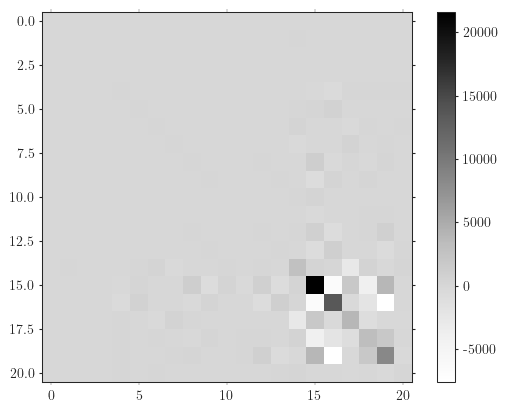

In [21]:
plt.imshow(tobj.hessian_fun(tobj.params,datas,tobj.zn,reperror=False,mureg=False,center=False)); plt.colorbar()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


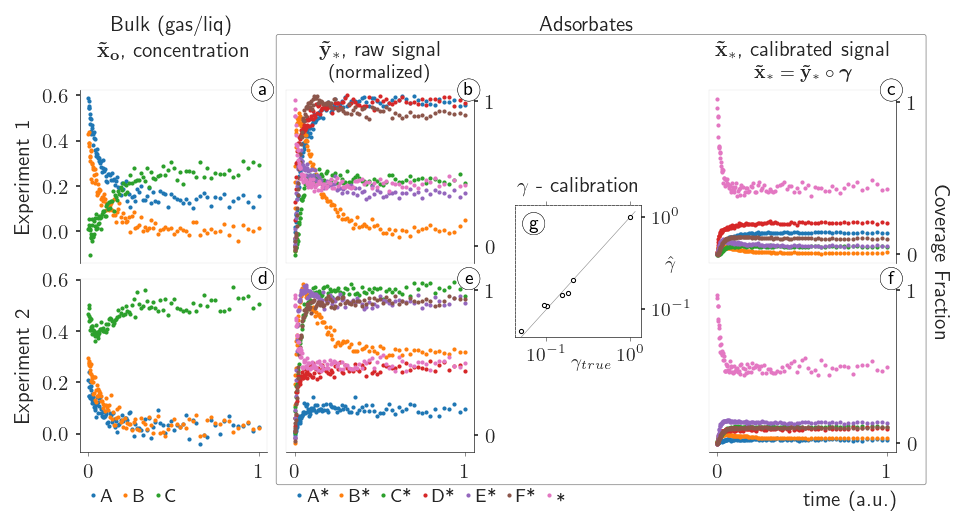

In [22]:
def plot():
    fig = plt.figure(figsize=(7, 5),dpi=150)

    # Sizes are in inches.

    #dx = 2.45
    dx = 1.25
    dy = 1.15/3.

    horiz = [Size.Fixed(dx), Size.Fixed(0.125), Size.Fixed(dx), Size.Fixed(0.275)]+[Size.Fixed(dy*2+0.075), Size.Fixed(0.45)]+[Size.Fixed(dx), Size.Fixed(0.125)]
    #vert = [Size.Fixed(dy), Size.Fixed(0.075)]*2
    vert = [Size.Fixed(dy), Size.Fixed(dy), Size.Fixed(dy), Size.Fixed(0.1075)]+[Size.Fixed(dy), Size.Fixed(dy), Size.Fixed(dy), Size.Fixed(0.1075)]

    rect = (0.01,0.01,0.02,0.02)
    # Divide the axes rectangle into a grid with sizes specified by horiz * vert.
    divider = Divider(fig, rect, horiz, vert, aspect=False)

    # The rect parameter will actually be ignored and overridden by axes_locator.

    axs = [[[] for i in range(3)] for j in range(2)]
    matching_dict = dict()
    delta = 1
    for j in range(2):
        for i in range(3):
            if i>1:
                i_ = i + 1
            else: 
                i_ = i
            if j>1:
                j_ = j + 1
            else: 
                j_ = j
            axs[j][i] = fig.add_axes(rect, axes_locator=divider.new_locator(nx=i_*2,ny=j_*4,ny1=j_*4+3))

    ax_arr = fig.add_axes(rect, axes_locator=divider.new_locator(nx=4,ny=2,ny1=5))


    def gen_data(t_eval,bc,pars):
        @jit
        def ode(t,C):
            return model_.single_eval([pars],[C]).flatten()
        sol = solve_ivp(ode, (t_eval[0], t_eval[-1]), bc, t_eval = t_eval, method='LSODA',atol=1e-20,rtol=1e-20)

        return t_eval.reshape(-1,1), sol.y.T
    ax = axs
    
    ls = []
    legs = [['A*', 'B*','C*','D*','E*','F*','*'],['A','B','C']]
        
    n = 1
        
    i = 1
    t_ = datas[0][0][::n]
    l1 = axs[0][0].plot(t_,datas[0][1][::n,:3],'.',ms=2,lw=0.05)
    l2 = axs[1][0].plot(t_,datas[1][1][::n,:3],'.',ms=2,lw=0.05)
    l1_ = axs[0][1].plot(t_,datas[0][1][::n,3:],'.',ms=2,lw=0.05)
    l2_ = axs[1][1].plot(t_,datas[1][1][::n,3:],'.',ms=2,lw=0.05)
    l1_s = axs[0][2].plot(t_,datas[0][1][::n,3:]*tobj.scales,'.',ms=2,lw=0.05)
    l2_s = axs[1][2].plot(t_,datas[1][1][::n,3:]*tobj.scales,'.',ms=2,lw=0.05)

    fix_color(l1,l2)
    legs = ['A', 'B','C']
    axs[1][0].legend(iter(l1), legs,ncol=3,loc=[0.0,-1.45],handletextpad=0.1,labelspacing=0.15,columnspacing=0.35,fontsize=9)

    fix_color(l1_,l2_)
    legs = ['A*', 'B*','C*','D*','E*','F*','*']
    leg2 = axs[1][1].legend(iter(l2_),[_ for _ in legs],ncol=7,loc=[0.0,-1.45],handletextpad=0.1,labelspacing=0.15,columnspacing=0.35,fontsize=9)

    axs[0][2].set_xlabel('time (a.u.)',ha='right',x=1.)
    axs[1][0].set_ylabel('Experiment 1')
    axs[0][0].set_ylabel('Experiment 2')
    axs[1][0].tick_params(labelbottom=False, labelleft=True)
    axs[1][1].tick_params(labelbottom=False, labeltop=False,labelleft=False,labelright=True)
    axs[1][2].set_ylabel('Coverage Fraction',va='bottom',y=0,rotation=-90.,ha='center',x=0.,labelpad=15)
    axs[1][1].yaxis.set_label_position("right")
    axs[1][1].yaxis.tick_right()
    axs[1][2].yaxis.set_label_position("right")
    axs[1][2].yaxis.tick_right()
    axs[0][1].yaxis.set_label_position("right")
    axs[0][1].yaxis.tick_right()
    axs[0][0].set_xlim([-0.05,1.05])

    for _ in axs:
        for ax in _:
            [i.set_linewidth(0.35)  for i in ax.spines.values()];
            plt.setp(ax.get_xticklabels(), visible=True)

    axs[1][0].spines['bottom'].set_linestyle("dashed")
    axs[1][0].spines['bottom'].set_linewidth(0.025)
    axs[1][0].spines['top'].set_linestyle("dashed")
    axs[1][0].spines['top'].set_linewidth(0.025)
    axs[1][1].spines['top'].set_linestyle("dashed")
    axs[1][1].spines['top'].set_linewidth(0.025)
    axs[1][2].spines['top'].set_linestyle("dashed")
    axs[1][2].spines['top'].set_linewidth(0.025)
    axs[1][0].spines['right'].set_linestyle("dashed")
    axs[1][0].spines['right'].set_linewidth(0.025)
    axs[0][0].spines['top'].set_linestyle("dashed")
    axs[0][0].spines['top'].set_linewidth(0.025)
    axs[0][0].spines['right'].set_linestyle("dashed")
    axs[0][0].spines['right'].set_linewidth(0.025)
    axs[1][0].yaxis.set_ticks_position('left')
    axs[1][0].xaxis.set_ticks_position('bottom')
    axs[1][0].set_xlim(axs[0][0].get_xlim())
    axs[1][0].set_xticks([])
    axs[1][1].set_xticks([])
    axs[1][2].set_xticks([])
    axs[0][0].xaxis.set_ticks_position('bottom')
    axs[0][0].yaxis.set_ticks_position('left')
    axs[0][0].xaxis.set_label_position('bottom')

    for j in [1,2]:
        axs[0][j].yaxis.set_ticks_position('right')
        axs[0][j].xaxis.set_ticks_position('bottom')
        axs[1][j].yaxis.set_ticks_position('right')
        # axs[1][1].xaxis.set_ticks_position('top')
        # axs[1][1].xaxis.set_label_position('top')
        axs[0][j].yaxis.set_ticks_position('right')
        axs[0][j].xaxis.set_ticks_position('bottom')
        #axs[1][1].tick_params(axis='x',direction="in")     
        axs[1][j].spines['bottom'].set_linestyle("dashed")
        axs[1][j].spines['bottom'].set_linewidth(0.025)
        axs[1][j].spines['left'].set_linestyle("dashed")
        axs[1][j].spines['left'].set_linewidth(0.025)
        axs[0][j].spines['top'].set_linestyle("dashed")
        axs[0][j].spines['top'].set_linewidth(0.025)
        axs[0][j].spines['left'].set_linestyle("dashed")
        axs[0][j].spines['left'].set_linewidth(0.025)
        #axs[1][1].xaxis.set_major_locator(plt.MaxNLocator(8,integer=True))
        axs[1][j].yaxis.set_major_locator(plt.MaxNLocator(6,integer=True))
        axs[0][j].yaxis.set_major_locator(plt.MaxNLocator(6,integer=True))
    # axs[0][1].xaxis.set_major_locator(plt.MaxNLocator(8,integer=True))
    # axs[0][1].yaxis.set_major_locator(plt.MaxNLocator(6,integer=True))

    for _ in ['top','left']:
        ax_arr.spines[_].set_linestyle("dashed")
        ax_arr.spines[_].set_linewidth(0.025)

    [i.set_linewidth(0.35)  for i in ax_arr.spines.values()]
    plt.setp(ax_arr.get_xticklabels(), visible=True)
    ax_arr.yaxis.set_ticks_position('right')
    ax_arr.yaxis.set_label_position('right')
    ax_arr.set_position([0,0,0.5,0.5])
    ax_arr.yaxis.set_major_locator(plt.MaxNLocator(6,integer=True))
    ax_arr.yaxis.set_major_locator(plt.MaxNLocator(6,integer=True))

    for j in range(3):
        axs[0][j].xaxis.set_major_locator(plt.MaxNLocator(6,integer=True))

    t1 = axs[1][0].text(.5,1.35,'Bulk (gas/liq)',
        horizontalalignment='center',
        transform=axs[1][0].transAxes,
        fontsize=10)
    axs[1][0].text(.5,1.2,r'$\mathbf{\tilde{x}_{o}}$, concentration',
        horizontalalignment='center',
        transform=axs[1][0].transAxes,
        fontsize=10)

    axs[1][1].text(.5,1.2,'$\mathbf{\\tilde{y}}_{\\ast}$, raw signal',
        horizontalalignment='center',
        transform=axs[1][1].transAxes,
        fontsize=10)
    axs[1][1].text(.5,1.075,'(normalized)',
        horizontalalignment='center',
        transform=axs[1][1].transAxes,
        fontsize=9)

    axs[1][2].text(.5,1.2,r'$\mathbf{\tilde{{x}}_{\ast}}$, calibrated signal',
        horizontalalignment='center',
        transform=axs[1][2].transAxes,
        fontsize=10)
    axs[1][2].text(.5,1.075,r'$\mathbf{\tilde{{x}}_{\ast}}=\mathbf{\tilde{{y}}_{\ast}}\circ{\boldsymbol{\gamma}}$',
            horizontalalignment='center',
        transform=axs[1][2].transAxes,
        fontsize=9)

    #ax_arr.axis('off')
    #plt.plot([0,0.15],[0.,0.15],'-')
    ax_arr.plot([0,1.15],[0.,1.15],'-',color='grey',lw=0.25)
    ax_arr.plot(s_,tobj.scales,'.',c='black',ms=4,mfc='white',mec='black',mew=0.5)
    ax_arr.set_title('$\gamma$ - calibration')
    ax_arr.set_xlabel('$\gamma_{true}$',fontsize=9,labelpad=-5,x=0.6)
    ax_arr.set_ylabel('$\hat{\gamma}$',fontsize=9,ha='center', y=.55,x=-0.5, va='center',rotation=0, labelpad=-10)
    ax_arr.xaxis.set_ticks([0,1],[0,1],fontsize=9)
    ax_arr.yaxis.set_ticks([0,1],[0,1],fontsize=9)
    ax_arr.set_xscale('log')
    ax_arr.set_yscale('log')

    ax_arr.set_position([0.,0.,0.,0.])


    rect = plt.matplotlib.patches.FancyBboxPatch((-0.095,-0.18), width=dx*2.95+0.1, height=dy*6+0.26-0.075+0.1,
                        transform=axs[0][1].get_xaxis_transform(), clip_on=False,
                        edgecolor="grey", facecolor="none", linewidth=.35,boxstyle='round,pad=0.05',mutation_scale=0.25)


    axs[0][0].add_patch(rect)   

    ax_arr.set_transform(t1.get_transform())

    t2 = axs[0][1].text(2.7,t1.get_position()[1],'Adsorbates',
        horizontalalignment='center',
        transform=axs[1][0].transAxes,
        fontsize=10)

    # t2.set_transform(t1.get_transform())
    # print(t2.get_position())
    plt.legend()                 
    _axs = [ax for aa in axs[::-1] for ax in aa]
    for txt,_ax, dx,dy in zip([ord('a')+_ for _ in range(len(_axs)+1)],_axs+[ax_arr],[0.025,0.025,0.025,0.025,0.025,0.025,0.85],[0.025,0.025,0.025,0.025,0.025,0.025,0.175]):
        plt.gcf().patches.extend([_ax.text(1-dx,1-dy,r'{}'.format(chr(txt)),
        horizontalalignment='center',
        transform=_ax.transAxes,
        fontsize=9,
        weight='bold',
        color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle,pad=0.15',lw=0.2,zorder=5),
        zorder=6)])

    [axs[_][a].set_ylim([axs[_][a].get_ylim()[0],1+0.075]) for _ in range(2) for a in range(1,3)]

    if __plot__:
        plt.savefig('latex_mle/figures/data_calibration.pdf',dpi=300,bbox_inches='tight')
        plt.savefig('latex_mle/figures/data_calibration.svg',dpi=300,bbox_inches='tight')
    return plt.gcf()
    
plot();

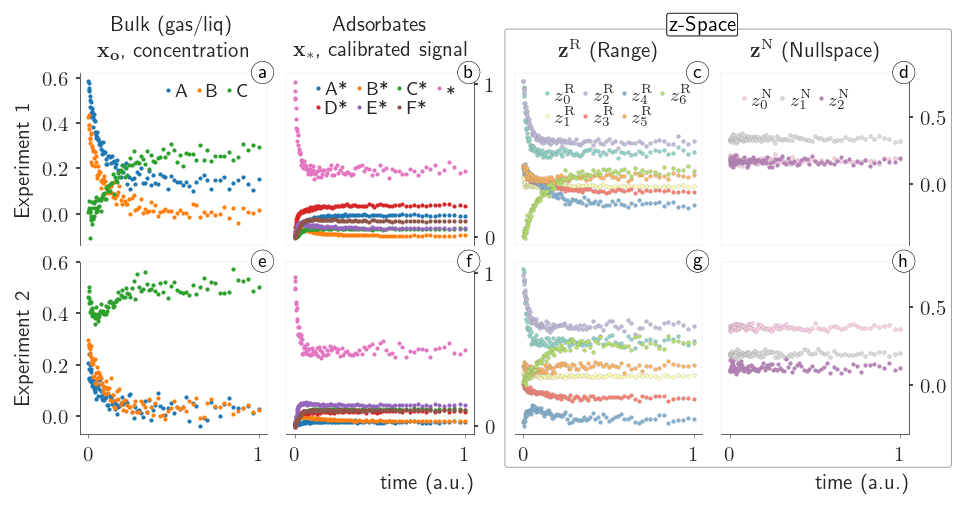

In [23]:
def plot():
    fig = plt.figure(figsize=(7, 5),dpi=150)

    # Sizes are in inches.

    #dx = 2.45
    dx = 1.25
    dy = 1.15/3.

    horiz = [Size.Fixed(dx), Size.Fixed(0.125), Size.Fixed(dx), Size.Fixed(0.275)]+[Size.Fixed(dx), Size.Fixed(0.125)]+[Size.Fixed(dx), Size.Fixed(0.125)]
    vert = [Size.Fixed(dy), Size.Fixed(dy), Size.Fixed(dy), Size.Fixed(0.1075)]+[Size.Fixed(dy), Size.Fixed(dy), Size.Fixed(dy), Size.Fixed(0.0)]

    rect = (0.01,0.01,0.02,0.02)
    # Divide the axes rectangle into a grid with sizes specified by horiz * vert.
    divider = Divider(fig, rect, horiz, vert, aspect=False)

    # The rect parameter will actually be ignored and overridden by axes_locator.

    axs = [[[] for i in range(4)] for j in range(2)]
    matching_dict = dict()
    delta = 1
    for j in range(2):
        for i in range(4):
            i_ = i
            j_ = j
            axs[j][i] = fig.add_axes(rect, axes_locator=divider.new_locator(nx=i_*2,ny=j_*4,ny1=j_*4+3))

    ax = axs
        
    ls = []
    legs = [['A*', 'B*','C*','D*','E*','F*','*'],['A','B','C']]
        
    axs[1][3].get_shared_y_axes().join(axs[1][3], axs[1][2])
    axs[0][3].get_shared_y_axes().join(axs[0][3], axs[0][2])
    axs[1][2].get_shared_x_axes().join(axs[1][2], axs[0][2])
    axs[1][3].get_shared_x_axes().join(axs[1][3], axs[0][3])

    n = 1
        
    i = 1
    t_ = datas[0][0][::n]
    l1 = axs[0][0].plot(t_,datas[0][1][::n,:3],'.',ms=2,lw=0.05,alpha=0.5)
    l2 = axs[1][0].plot(t_,datas[1][1][::n,:3],'.',ms=2,lw=0.05,alpha=0.5)
    l1r = axs[0][2].plot(t_,(datas[0][1][::n,:]*(jnp.concatenate((jnp.ones(3),tobj.scales)))).dot(tobj.Ur),'.',ms=2,lw=0.05,alpha=0.5)
    l2r = axs[1][2].plot(t_,(datas[1][1][::n,:]*(jnp.concatenate((jnp.ones(3),tobj.scales)))).dot(tobj.Ur),'.',ms=2,lw=0.05,alpha=0.5)
    for la,lb,c in zip(l1r,l2r,plt.cm.Set3.colors[:len(l1r)]):
        la.set_color(c)
        lb.set_color(c)
    l1n = axs[0][3].plot(t_,(datas[0][1][::n,:]*(jnp.concatenate((jnp.ones(3),tobj.scales)))).dot(tobj.Un),'.',ms=2,lw=0.05,alpha=0.5)
    l2n = axs[1][3].plot(t_,(datas[1][1][::n,:]*(jnp.concatenate((jnp.ones(3),tobj.scales)))).dot(tobj.Un),'.',ms=2,lw=0.05,alpha=0.5)
    for la,lb,c in zip(l1n,l2n,plt.cm.Set3.colors[len(l1r):len(l1r)+len(l1n)]):
        la.set_color(c)
        lb.set_color(c)
    l1_s = axs[0][1].plot(t_,datas[0][1][::n,3:]*tobj.scales,'.',ms=2,lw=0.05,alpha=0.5)
    l2_s = axs[1][1].plot(t_,datas[1][1][::n,3:]*tobj.scales,'.',ms=2,lw=0.05,alpha=0.5)

    fix_color(l1,l2)

    for l in [l1r,l2r,l1n,l2n]:
        for _ in l:
            _.set(ms=3.7,alpha=1.,mec='grey',mew=.1,)
            #_.set(mec=_.get_mfc())

    for l in [l1,l2,l1_s,l2_s]:
        for _ in l:
            _.set(ms=2.,alpha=1)


    legs = ['A', 'B','C']
    axs[1][0].legend(iter(l1), legs,ncol=3,loc=[0.4,.8],handletextpad=0.1,labelspacing=0.1,columnspacing=0.25,fontsize=9)
    legs = ['A*', 'B*','C*','D*','E*','F*','*']
    leg2 = axs[1][1].legend(iter([l1_s[_] for _ in [0,3,1,4,2,5,6]]),[legs[_] for _ in [0,3,1,4,2,5,6]],ncol=4,loc=[0.1,.7],\
        handletextpad=0.1,labelspacing=0.125,columnspacing=0.25,fontsize=9)
    axs[1][2].legend(iter(l1r), ['$z_{}^\mathrm{{R}}$'.format(i) for i in range(len(l1r))],ncol=4,loc=[0.1,.65],handletextpad=0.1,labelspacing=0.125,columnspacing=0.25,fontsize=9)
    axs[1][3].legend(iter(l1n), ['$z_{}^\mathrm{{N}}$'.format(i) for i in range(len(l1n))],ncol=3,loc=[0.05,.75],handletextpad=0.1,labelspacing=0.125,columnspacing=0.25,fontsize=9)


    axs[0][1].set_xlabel('time (a.u.)',ha='right',x=1.)
    axs[0][3].set_xlabel('time (a.u.)',ha='right',x=1.)
    axs[1][0].set_ylabel('Experiment 1')
    axs[0][0].set_ylabel('Experiment 2')
    axs[1][0].tick_params(labelbottom=False, labelleft=True)
    axs[1][1].tick_params(labelbottom=False, labeltop=False,labelleft=False,labelright=True)
    #axs[1][2].set_ylabel('$\dot{\mathbf{x}}$',va='bottom',y=0,rotation=0.,ha='center',x=0.,labelpad=5)
    axs[1][1].yaxis.set_label_position("right")
    axs[1][1].yaxis.tick_right()
    axs[1][2].yaxis.set_label_position("right")
    axs[1][2].yaxis.tick_right()
    axs[0][1].yaxis.set_label_position("right")
    axs[0][1].yaxis.tick_right()
    axs[0][0].set_xlim([-0.05,1.05])

    for _ in axs:
        for ax in _:
            [i.set_linewidth(0.35)  for i in ax.spines.values()];
            plt.setp(ax.get_xticklabels(), visible=True)

    axs[1][0].spines['bottom'].set(linestyle="dashed",linewidth=0.025)
    axs[1][0].spines['top'].set(linestyle="dashed",linewidth=0.025)
    axs[1][1].spines['top'].set(linestyle="dashed",linewidth=0.025)
    axs[1][2].spines['top'].set(linestyle="dashed",linewidth=0.025)
    axs[1][0].spines['right'].set_linestyle("dashed")
    axs[1][0].spines['right'].set_linewidth(0.025)
    axs[0][0].spines['top'].set_linestyle("dashed")
    axs[0][0].spines['top'].set_linewidth(0.025)
    axs[0][0].spines['right'].set_linestyle("dashed")
    axs[0][0].spines['right'].set_linewidth(0.025)
    axs[1][0].yaxis.set_ticks_position('left')
    axs[1][0].xaxis.set_ticks_position('bottom')
    axs[1][0].set_xlim(axs[0][0].get_xlim())
    axs[1][0].set_xticks([])
    axs[1][1].set_xticks([])
    axs[1][2].set_xticks([])
    axs[1][3].set_xticks([])
    axs[0][2].set_yticks([])
    axs[1][2].set_yticks([])
    axs[0][0].xaxis.set_ticks_position('bottom')
    axs[0][0].yaxis.set_ticks_position('left')
    axs[0][0].xaxis.set_label_position('bottom')

    for j in [1]:
        axs[0][j].yaxis.set_ticks_position('right')
        axs[0][j].xaxis.set_ticks_position('bottom')
        axs[1][j].yaxis.set_ticks_position('right')
        axs[0][j].yaxis.set_ticks_position('right')
        axs[0][j].xaxis.set_ticks_position('bottom')
        axs[1][j].spines['bottom'].set_linestyle("dashed")
        axs[1][j].spines['bottom'].set_linewidth(0.025)
        axs[1][j].spines['left'].set_linestyle("dashed")
        axs[1][j].spines['left'].set_linewidth(0.025)
        axs[0][j].spines['top'].set_linestyle("dashed")
        axs[0][j].spines['top'].set_linewidth(0.025)
        axs[0][j].spines['left'].set_linestyle("dashed")
        axs[0][j].spines['left'].set_linewidth(0.025)
        axs[1][j].yaxis.set_major_locator(plt.MaxNLocator(6,integer=True))
        axs[0][j].yaxis.set_major_locator(plt.MaxNLocator(6,integer=True))

    axs[0][2].spines['left'].set(linestyle="dashed",linewidth=0.025)
    axs[0][2].spines['top'].set(linestyle="dashed",linewidth=0.025)
    axs[0][2].spines['right'].set(linestyle="dashed",linewidth=0.025)
    axs[1][2].spines['left'].set(linestyle="dashed",linewidth=0.025)
    axs[1][2].spines['top'].set(linestyle="dashed",linewidth=0.025)
    axs[1][2].spines['right'].set(linestyle="dashed",linewidth=0.025)
    axs[1][2].spines['bottom'].set(linestyle="dashed",linewidth=0.025)
    axs[0][3].spines['left'].set(linestyle="dashed",linewidth=0.025)
    axs[0][3].spines['top'].set(linestyle="dashed",linewidth=0.025)
    axs[1][3].spines['left'].set(linestyle="dashed",linewidth=0.025)
    axs[1][3].spines['top'].set(linestyle="dashed",linewidth=0.025)
    axs[1][3].spines['bottom'].set(linestyle="dashed",linewidth=0.025)
    axs[0][3].yaxis.set_ticks_position('right')
    axs[0][3].xaxis.set_label_position('bottom')
    axs[0][2].xaxis.set_ticks_position('bottom')
    axs[0][3].xaxis.set_ticks_position('bottom')
    axs[1][3].yaxis.set_ticks_position('right')
    #axs[1][3].xaxis.set_label_position('bottom')

    for j in range(4):
        axs[0][j].xaxis.set_major_locator(plt.MaxNLocator(6,integer=True))

    t1 = axs[1][0].text(.5,1.25,'Bulk (gas/liq)',
        horizontalalignment='center',
        transform=axs[1][0].transAxes,
        fontsize=10)
    axs[1][0].text(.5,1.1,'$\mathbf{x_{o}}$, concentration',
        horizontalalignment='center',
        transform=axs[1][0].transAxes,
        fontsize=10)

    axs[1][1].text(.5,1.1,'$\mathbf{x_{\\ast}}$, calibrated signal',
        horizontalalignment='center',
        transform=axs[1][1].transAxes,
        fontsize=10)

    # axs[1][2].text(1.,1.25,'z-Space',
    #     horizontalalignment='center',
    #     transform=axs[1][2].transAxes,
    #     fontsize=10)


    plt.gcf().patches.extend([axs[1][2].text(1.,1.25,'z-Space',
        horizontalalignment='center',
        transform=axs[1][2].transAxes,
        fontsize=10,
        weight='bold',
        color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.1',lw=0.35,zorder=5),
        zorder=6)])

    axs[1][2].text(.5,1.1,'$\mathbf{z}^\mathrm{R}$ (Range)',
        horizontalalignment='center',
        transform=axs[1][2].transAxes,
        fontsize=10)

    axs[1][3].text(.5,1.1,'$\mathbf{z}^\mathrm{N}$ (Nullspace)',
        horizontalalignment='center',
        transform=axs[1][3].transAxes,
        fontsize=10)

    rect = plt.matplotlib.patches.FancyBboxPatch((-0.095,-0.18), width=dx*2.075, height=dy*6+0.14+0.075,
                        transform=axs[0][2].get_xaxis_transform(), clip_on=False,
                        edgecolor="grey", facecolor="none", linewidth=.35,boxstyle='round,pad=0.05',mutation_scale=0.25)

    axs[0][2].add_patch(rect)   

    t2 = axs[1][1].text(.5,t1.get_position()[1],'Adsorbates',
        horizontalalignment='center',
        transform=axs[1][1].transAxes,
        fontsize=10)

    # t2.set_transform(t1.get_transform())
    # print(t2.get_position())
    #plt.legend()   
    _axs = [ax for aa in axs[::-1] for ax in aa]
    for txt,_ax, dx,dy in zip([ord('a')+_ for _ in range(len(_axs)+1)],_axs,[0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025],[0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025]):
        plt.gcf().patches.extend([_ax.text(1-dx,1-dy,r'{}'.format(chr(txt)),
        horizontalalignment='center',
        transform=_ax.transAxes,
        fontsize=9,
        weight='bold',
        color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle,pad=0.15',lw=0.2,zorder=5),
        zorder=6)])  
        [axs[_][a].set_ylim([axs[_][a].get_ylim()[0],1+0.075]) for _ in range(2) for a in range(1,2)]

    if __plot__:
        plt.savefig('latex_mle/figures/data_z_space.pdf',dpi=300,bbox_inches='tight')
        plt.savefig('latex_mle/figures/data_z_space.svg',dpi=300,bbox_inches='tight')
    return plt.gcf()
plot();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


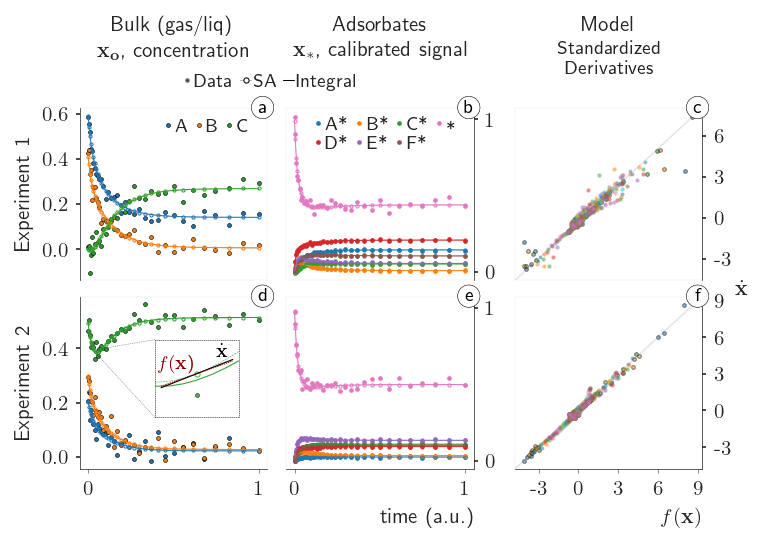

In [24]:
def plot():
    fig = plt.figure(figsize=(7, 5),dpi=150)

    # Sizes are in inches.

    #dx = 2.45
    dx = 1.25
    dy = 1.15

    horiz = [Size.Fixed(dx), Size.Fixed(0.125), Size.Fixed(dx), Size.Fixed(0.275)]+[Size.Fixed(dx), Size.Fixed(0.125)]
    vert = [Size.Fixed(dy), Size.Fixed(0.1075)]+[Size.Fixed(dy), Size.Fixed(0.1075)]
    #vert = [Size.Fixed(dy), Size.Fixed(dy), Size.Fixed(dy), Size.Fixed(0.095)]+[Size.Fixed(dy), Size.Fixed(dy), Size.Fixed(dy), Size.Fixed(0.075)]

    rect = (0.01,0.01,0.02,0.02)
    # Divide the axes rectangle into a grid with sizes specified by horiz * vert.
    divider = Divider(fig, rect, horiz, vert, aspect=False)

    # The rect parameter will actually be ignored and overridden by axes_locator.

    axs = [[[] for i in range(3)] for j in range(2)]
    matching_dict = dict()
    delta = 1
    for j in range(2):
        for i in range(3):
            i_ = i
            j_ = j
            axs[j][i] = fig.add_axes(rect, axes_locator=divider.new_locator(nx=i_*2,ny=j_*2))
            
    def gen_data(t_eval,bc,pars):
        @jit
        def ode(t,C):
            return model_.single_eval([pars],[C]).flatten()
        sol = solve_ivp(ode, (t_eval[0], t_eval[-1]), bc, t_eval = t_eval, method='LSODA',atol=1e-20,rtol=1e-20)

        return t_eval.reshape(-1,1), sol.y.T

    ax = axs
        
    ls = []
    legs = [['A*', 'B*','C*','D*','E*','F*','*'],['A','B','C']]
        
    n = 3
        
    i = 1
    t_ = datas[0][0][::n]
    def intra_points(t,n):
        if n > 0:
            return jnp.sort(jnp.vstack((t,jnp.vstack((t[:-1,:]+jnp.diff(t,axis=0)/(n+1)*(i+1) for i in range(n))))),axis=0)
        else:
            return t
    tinterp = intra_points(t_,5)
    l1 = axs[0][0].plot(t_,datas[0][1][::n,:3],'.',ms=2,lw=0.05,alpha=0.5)
    l2 = axs[1][0].plot(t_,datas[1][1][::n,:3],'.',ms=2,lw=0.05,alpha=0.5)
    mpars = tobj.params['pm'][0]
    t0, xode0 = gen_data(jnp.sort(datas[0][2].flatten()),tobj.nn[0].batched_state(tobj.params['sm'][0],datas[0][2][:1],tobj.zn[0])[0],mpars)
    t1, xode1 = gen_data(jnp.sort(datas[1][2].flatten()),tobj.nn[1].batched_state(tobj.params['sm'][1],datas[1][2][:1],tobj.zn[1])[0],mpars)
    l1n = axs[0][0].plot(t_,tobj.nn[0].batched_state(tobj.params['sm'][0],t_,tobj.zn[0])[:,:3],'o',ms=1.5,mew=0.5,lw=0.05,mfc='None')
    l1n_l = axs[0][0].plot(tinterp,tobj.nn[0].batched_state(tobj.params['sm'][0],tinterp,tobj.zn[0])[:,:3],ls=(0,(1,1)),ms=1.5,mew=0.5,lw=0.25,mfc='None')
    l2n = axs[1][0].plot(t_,tobj.nn[1].batched_state(tobj.params['sm'][1],t_,tobj.zn[1])[:,:3],'o',ms=1.5,mew=0.5,lw=0.05,mfc='None')
    l2n_l = axs[1][0].plot(tinterp,tobj.nn[1].batched_state(tobj.params['sm'][1],tinterp,tobj.zn[1])[:,:3],ls=(0,(1,1)),ms=1.5,mew=0.5,lw=0.25,mfc='None')
    l1i = axs[0][0].plot(t0,xode0[:,:3],'-',ms=1.5,mew=0.5,lw=0.5,mfc='None')
    l2i = axs[1][0].plot(t1,xode1[:,:3],'-',ms=1.5,mew=0.5,lw=0.5,mfc='None')
    # l1_ = axs[0][1].plot(t_,datas[0][1][::n,3:],'.',ms=2,lw=0.05)
    # l2_ = axs[1][1].plot(t_,datas[1][1][::n,3:],'.',ms=2,lw=0.05)
    l1_s = axs[0][1].plot(t_,datas[0][1][::n,3:]*tobj.scales,'.',ms=2,lw=0.05,alpha=0.5)
    l2_s = axs[1][1].plot(t_,datas[1][1][::n,3:]*tobj.scales,'.',ms=2,lw=0.05,alpha=0.5)
    l1n_s = axs[0][1].plot(t_,tobj.nn[0].batched_state(tobj.params['sm'][0],t_,tobj.zn[0])[:,3:],'o',ms=1.5,mew=.5,lw=0.05,mfc='None')
    l1n_s_l = axs[0][1].plot(tinterp,tobj.nn[0].batched_state(tobj.params['sm'][0],tinterp,tobj.zn[0])[:,3:],ls=(0,(1,1)),ms=1.5,mew=0.5,lw=0.25,mfc='None')
    l2n_s = axs[1][1].plot(t_,tobj.nn[1].batched_state(tobj.params['sm'][1],t_,tobj.zn[1])[:,3:],'o',ms=1.5,mew=.5,lw=0.05,mfc='None')
    l2n_s_l = axs[1][1].plot(tinterp,tobj.nn[1].batched_state(tobj.params['sm'][1],tinterp,tobj.zn[1])[:,3:],ls=(0,(1,1)),ms=1.5,mew=0.5,lw=0.25,mfc='None')
    l1i_s = axs[0][1].plot(t0,xode0[:,3:],'-',ms=1.5,mew=0.5,lw=0.5,mfc='None')
    l2i_s = axs[1][1].plot(t1,xode1[:,3:],'-',ms=1.5,mew=0.5,lw=0.5,mfc='None')
    #l2 = axs[i][0].plot(t_,xnn[::n,:3],'o-',lw=0.1,ms=4,markerfacecolor='None',markeredgecolor='black',markeredgewidth=0.3)

    fix_color(l1,l2)
    fix_color(l1,l1n)
    fix_color(l2,l2n)
    fix_color(l1,l1i)
    fix_color(l2,l2i)
    fix_color(l1_s,l1n_s)
    fix_color(l2_s,l2n_s)
    fix_color(l1_s,l1i_s)
    fix_color(l2_s,l2i_s)
    
    fix_color(l1n,l1n_l)
    fix_color(l1n,l1n_l)
    fix_color(l1n_s,l1n_s_l)
    fix_color(l2n_s,l2n_s_l)

    for l in [l1,l2]:
        for _ in l:
            _.set(mec='black',mew=0.3,ms=3.75,alpha=1)

    for l in [l1_s,l2_s]:
        for _ in l:
            _.set(ms=2.5,alpha=1)

    legs = ['A', 'B','C']
    #axs[1][0].legend(iter(l1), legs,ncol=1,loc=[0.75,0.6],handletextpad=0.1,labelspacing=0.15,fontsize=9)
    axs[1][0].legend(iter(l1), legs,ncol=3,loc=[0.4,.8],handletextpad=0.1,labelspacing=0.1,columnspacing=0.25,fontsize=9)

    fix_color(l1,l2)
    legs = ['A*', 'B*','C*','D*','E*','F*','*']
    #leg2 = axs[1][1].legend(iter(l2_),[_ for _ in legs],ncol=7,loc=[0.0,-1.45],handletextpad=0.1,labelspacing=0.15,columnspacing=0.35,fontsize=9)
    leg2 = axs[1][1].legend(iter([l2_s[_] for _ in [0,3,1,4,2,5,6]]),[legs[_] for _ in [0,3,1,4,2,5,6]],ncol=4,loc=[0.1,.7],handletextpad=0.1,labelspacing=0.125,columnspacing=0.25,fontsize=9)

    #axs[0][1].set_xlabel('time (a.u.)',ha='right',x=1.)
    axs[0][1].set_xlabel('time (a.u.)',ha='right',x=1.)
    axs[0][2].set_xlabel('$f(\mathbf{x})$',ha='right',x=1.)#,fontsize=9)
    axs[1][0].set_ylabel('Experiment 1')
    axs[0][0].set_ylabel('Experiment 2')
    axs[1][0].tick_params(labelbottom=False, labelleft=True)
    axs[1][1].tick_params(labelbottom=False, labeltop=False,labelleft=False,labelright=True)
    axs[1][2].set_ylabel('$\dot{\mathbf{x}}$',va='bottom',y=0,rotation=0.,ha='center',x=0.,labelpad=5)
    axs[1][1].yaxis.set_label_position("right")
    axs[1][1].yaxis.tick_right()
    axs[1][2].yaxis.set_label_position("right")
    axs[1][2].yaxis.tick_right()
    axs[0][1].yaxis.set_label_position("right")
    axs[0][1].yaxis.tick_right()
    axs[0][0].set_xlim([-0.05,1.05])

    for _ in axs:
        for ax in _:
            [i.set_linewidth(0.35)  for i in ax.spines.values()];
            plt.setp(ax.get_xticklabels(), visible=True)

    axs[1][0].spines['bottom'].set_linestyle("dashed")
    axs[1][0].spines['bottom'].set_linewidth(0.025)
    axs[1][0].spines['top'].set_linestyle("dashed")
    axs[1][0].spines['top'].set_linewidth(0.025)
    axs[1][1].spines['top'].set_linestyle("dashed")
    axs[1][1].spines['top'].set_linewidth(0.025)
    axs[1][2].spines['top'].set_linestyle("dashed")
    axs[1][2].spines['top'].set_linewidth(0.025)
    axs[1][0].spines['right'].set_linestyle("dashed")
    axs[1][0].spines['right'].set_linewidth(0.025)
    axs[0][0].spines['top'].set_linestyle("dashed")
    axs[0][0].spines['top'].set_linewidth(0.025)
    axs[0][0].spines['right'].set_linestyle("dashed")
    axs[0][0].spines['right'].set_linewidth(0.025)
    axs[1][0].yaxis.set_ticks_position('left')
    axs[1][0].xaxis.set_ticks_position('bottom')
    axs[1][0].set_xlim(axs[0][0].get_xlim())
    axs[1][0].set_xticks([])
    axs[1][1].set_xticks([])
    axs[1][2].set_xticks([])
    axs[0][0].xaxis.set_ticks_position('bottom')
    axs[0][0].yaxis.set_ticks_position('left')
    axs[0][0].xaxis.set_label_position('bottom')

    for j in [1,2]:
        axs[0][j].yaxis.set_ticks_position('right')
        axs[0][j].xaxis.set_ticks_position('bottom')
        axs[1][j].yaxis.set_ticks_position('right')
        axs[0][j].yaxis.set_ticks_position('right')
        axs[0][j].xaxis.set_ticks_position('bottom')
        axs[1][j].spines['bottom'].set_linestyle("dashed")
        axs[1][j].spines['bottom'].set_linewidth(0.025)
        axs[1][j].spines['left'].set_linestyle("dashed")
        axs[1][j].spines['left'].set_linewidth(0.025)
        axs[0][j].spines['top'].set_linestyle("dashed")
        axs[0][j].spines['top'].set_linewidth(0.025)
        axs[0][j].spines['left'].set_linestyle("dashed")
        axs[0][j].spines['left'].set_linewidth(0.025)
        axs[1][j].yaxis.set_major_locator(plt.MaxNLocator(6,integer=True))
        axs[0][j].yaxis.set_major_locator(plt.MaxNLocator(6,integer=True))

    for j in range(3):
        axs[0][j].xaxis.set_major_locator(plt.MaxNLocator(6,integer=True))

    t1 = axs[1][0].text(.5,1.45,'Bulk (gas/liq)',
        horizontalalignment='center',
        transform=axs[1][0].transAxes,
        fontsize=10)
    axs[1][0].text(.5,1.3,'$\mathbf{x_{o}}$, concentration',
        horizontalalignment='center',
        transform=axs[1][0].transAxes,
        fontsize=10)

    axs[1][1].text(.5,1.3,'$\mathbf{x_{\\ast}}$, calibrated signal',
        horizontalalignment='center',
        transform=axs[1][1].transAxes,
        fontsize=10)

    axs[1][2].text(.5,1.45,'Model',
        horizontalalignment='center',
        transform=axs[1][2].transAxes,
        fontsize=10)

    axs[1][2].text(.5,1.2,'Standardized\nDerivatives',
        horizontalalignment='center',
        transform=axs[1][2].transAxes,
        fontsize=9)

    # rect = plt.matplotlib.patches.FancyBboxPatch((-0.095,-0.18), width=dx*2.95, height=dy*6+0.26,
    #                      transform=axs[0][1].get_xaxis_transform(), clip_on=False,
    #                      edgecolor="grey", facecolor="none", linewidth=.35,boxstyle='round,pad=0.05',mutation_scale=0.25)

    # axs[0][0].add_patch(rect)   

    t2 = axs[1][1].text(.5,t1.get_position()[1],'Adsorbates',
        horizontalalignment='center',
        transform=axs[1][1].transAxes,
        fontsize=10)

    # t2.set_transform(t1.get_transform())
    # print(t2.get_position())
    plt.legend()      

    legend_elements = [Line2D([0], [0], color='black',marker='.',ms=2.5,lw=0.0,alpha=0.5, label='Data'),
                    Line2D([0], [0], marker='o', color='black',ms=2.5,mew=.5,lw=0.25,ls=(0,(1,1)),mfc='white', label='SA'),
                    Line2D([0], [0], linestyle='-',ms=1.5,mew=0.5,lw=0.5,color='black',mfc='None', label='Integral')]

    axs[0][0].legend(handles=legend_elements,ncol=3,loc=[0.5,2.075+0.075],handletextpad=0.1,labelspacing=0.15,\
        columnspacing=0.35,fontsize=9,bbox_transform=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.1',lw=0.5,zorder=-10),)

    mpars = tobj.params['pm'][0]
    for _ in [0,1]:#range(len(datas0)):
        ts = datas[_][0]
        ts_ = datas[_][2]
        x0_ = tobj.nn[_].batched_state(tobj.params['sm'][_],ts[:1],tobj.zn[_])[0]
        _t, xode = gen_data(ts.flatten(),x0_,mpars)
        xnn = tobj.nn[_].batched_state(tobj.params['sm'][_],ts,tobj.zn[_])
        xnn_ = tobj.nn[_].batched_state(tobj.params['sm'][_],ts_,tobj.zn[_])
        dxnn = tobj.nn[_].diff_state(tobj.params['sm'][_],ts,tobj.zn[_])[:,:,0]
        dxnn_ = tobj.nn[_].diff_state(tobj.params['sm'][_],ts_,tobj.zn[_])[:,:,0]
        fx  = model_.batched_eval([mpars],[xnn])
        fx_  = model_.batched_eval([mpars],[xnn_])
        xs  = datas[_][1]
        xs0 = datas0[_][1]

        i = _
        ls = []
        legs = [['A*', 'B*','C*','D*','E*','F*','*'],['A','B','C']]
        ds0 = fx_
        ds1 = dxnn_
        ds0, ds1 = [(ds-jnp.vstack((ds0,ds1)).mean(axis=0))/jnp.vstack((ds0,ds1)).std(axis=0) for ds in [ds0,ds1]]
        ls = []
        for n,(a,b) in enumerate(zip(ds0,ds1)):
            ls = axs[i][2].plot(a,b,c='C{}'.format(n if n<3 else n-3),marker='o',lw=0,ms=2 if n>3 else 1.75,mec='black' if n<3 else 'None',mew=0.5 if n<3 else 0,alpha=0.5)
        
        #leg1 = axs[i][1].legend(iter(ls), legs[i],ncol=5,loc=[0.05,0.75],labelspacing=0.35)
        #leg1 = axs[i][2].legend(iter(ls), legs[i],ncol=5,labelspacing=0.35)
        bounds = list(axs[i][2].get_xbound())+list(axs[i][2].get_ybound())
        newbounds = [min(bounds)-0.025,max(bounds)+0.1]
        L = 20
        axs[i][2].plot([-L,L],[-L,L],'-',lw=0.8,alpha=0.2,color='grey')
        axs[i][2].set_xlim(newbounds)
        axs[i][2].set_ylim(newbounds)

    axins = axs[0][0].inset_axes([0.4, 0.3, 0.45, 0.45])

    n = 5
    t_ = datas[0][0][::n]
    ins_l1 = axins.plot(t_,datas[0][1][::n,:3],'.',ms=2,lw=0.05,alpha=0.5)
    xnwin = tobj.nn[0].batched_state(tobj.params['sm'][0],t_,tobj.zn[0])
    xnwin_l = tobj.nn[0].batched_state(tobj.params['sm'][0],tinterp,tobj.zn[0])
    wpos = 5
    tpos = t_[wpos]
    ypos = xnwin[wpos,2]-0.001
    dtx = 0.010
    dty = 0.008
    window = dict(xlim=(tpos-dtx,tpos+dtx),ylim=(ypos-dty,ypos+dty))
    ins_l1n = axins.plot(t_,xnwin[:,:3],'o',ms=1.5,mew=0.5,lw=0.05,mfc='None')
    ins_l1n_l = axins.plot(tinterp,xnwin_l[:,:3],'--',ms=1.5,mew=0.5,lw=0.25,mfc='None')
    ins_l1i = axins.plot(t0,xode0[:,:3],'-',ms=1.5,mew=0.5,lw=0.5,mfc='None')
    twin = t_[(t_>window['xlim'][0])*(t_<=window['xlim'][1])].reshape(-1,1)
    xwin = tobj.nn[0].batched_state(tobj.params['sm'][0],twin,tobj.zn[0])[:,:]
    dxnn_win  = tobj.nn[0].diff_state(tobj.params['sm'][0],twin,tobj.zn[0])[:,:,0]
    fx_win  = model_.batched_eval([mpars],[xwin])
    xs  = datas[_][1]

    fix_color(l1,ins_l1)
    fix_color(l1n,ins_l1n)
    fix_color(ins_l1n,ins_l1n_l)
    fix_color(ins_l1,ins_l1i)

    for l in [ins_l1]:
        for _ in l:
            _.set(mec='black',mew=0.3,ms=3.75,alpha=.8)

    for l in [ins_l1n]:
        for _ in l:
            _.set(ms=2.5,alpha=.8)

    axins.set(xticks=[],yticks=[], **window)
    axins.tick_params(top=False,labelbottom=False, labeltop=False,labelleft=False,labelright=False)
    izoom = axs[0][0].indicate_inset_zoom(axins,lw=0.35,ec='black',linestyle=(0,(1,2)))
    dt = jnp.diff(jnp.array(list(window['xlim'])).flatten())*0.85
    inds = jnp.array([int(1.3*len(xwin)/2.)])
    for t__,x,dxnn,fx in zip(twin[inds,:],xwin[inds,2],dxnn_win[inds,2],fx_win[inds,2]):
        dtwin = jnp.linspace(-dt/2,dt/2,20)
        dxwin = x+dxnn*dtwin
        fxwin = x+fx*dtwin
        axins.plot(t__+dtwin,dxwin,ls='-',lw=0.55,c='black')
        axins.plot(t__+dtwin,fxwin,ls=(0,(1,1)),lw=0.55,c='darkred')
        axins.text((t__+dtwin)[-1]-0.004,dxwin[-1]+0.00055,'$\dot{\mathbf{x}}$',fontsize=9,c='black')
        axins.text((t__+dtwin)[0]-0.0007,fxwin[0]+0.0035,'$f(\mathbf{x}$)',fontsize=9,c='darkred')
    [_.set(color='black',lw=0.3,ls=(0,(1,2))) for _ in izoom[1]]
    [i.set(lw=0.3,ls=(0,(1,2))) for i in axins.spines.values()]
    
    _axs = [ax for aa in axs[::-1] for ax in aa]
    for txt,_ax, dx,dy in zip([ord('a')+_ for _ in range(len(_axs)+1)],_axs,[0.025,0.025,0.025,0.025,0.025,0.025],[0.025,0.025,0.025,0.025,0.025,0.025]):
        plt.gcf().patches.extend([_ax.text(1-dx,1-dy,r'{}'.format(chr(txt)),
        horizontalalignment='center',
        transform=_ax.transAxes,
        fontsize=9,
        weight='bold',
        color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle,pad=0.15',lw=0.2,zorder=5),
        zorder=6)])  
        [axs[_][a].set_ylim([axs[_][a].get_ylim()[0],1+0.075]) for _ in range(2) for a in range(1,2)]
    
    if __plot__:
        plt.savefig('latex_mle/figures/data_mle_results.pdf',dpi=300,bbox_inches='tight')
        plt.savefig('latex_mle/figures/data_mle_results.svg',dpi=300,bbox_inches='tight')
plot()